# Home Credit Default Risk - Kaggle competition
Chelsea's first Jupyter Notebook and Kaggle competition.

# Initial Setup

In [105]:
# To display plots properly
%matplotlib inline

# Load packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import os
 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [79]:
# Load data

file_path = "C:/Users/DS Miranda/Documents/Work/Kaggle_Home_Credit_Default_Risk/"

# List files available
print(os.listdir(file_path))

# Training data
app_train = pd.read_csv(file_path + 'application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# Test data
app_test = pd.read_csv(file_path + 'application_test.csv')
print('Test data shape: ', app_test.shape)
# app_test.head()


['all.zip', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'EDA.py', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
Training data shape:  (307511, 122)
Test data shape:  (48744, 121)


## Exploratory Data Analysis

### Examine distribution of target column

In [16]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

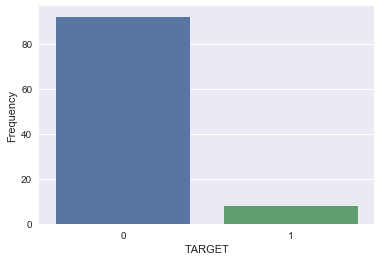

In [39]:
ax = sns.barplot(x="TARGET", y="TARGET", data=app_train, estimator=lambda x: len(x) / len(app_train) * 100, );
ax.set(ylabel='Frequency');
plt.show()

We appear to have an imbalanced class problem. Many more people were classified as repaying loans on time (0) than not (1).

### Examine missing values
Next look at the number and percentage of missing values in each column. Missing values will need to be imputed before applying most machine learning models.

In [45]:
def missing_vals_table(df):
    # Function to calculate missing values by column
    
    # Total number of missing values
    mv = df.isnull().sum()
    
    # Percentage of values that are missing
    mv_pc = 100*df.isnull().sum()/len(df)
    
    # Create table with results
    mv_tbl = pd.concat([mv, mv_pc], axis=1)
    
    # Rename columns
    mv_tbl_rn = mv_tbl.rename(
    columns = {0:'Missing Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mv_tbl_rn =mv_tbl_rn[
        mv_tbl_rn.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print summary info
    print('Dataframe has ' + str(df.shape[1]) + ' columns.\n' +
         'There are ' + str(mv_tbl_rn.shape[0]) + 
         ' columns with missing values.')
    
    return mv_tbl_rn
    

In [47]:
# Missing values statistics
missing_values = missing_vals_table(app_train)
missing_values.head(10)

Dataframe has 122 columns.
There are 67 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Column types

In [48]:
# Number of each column type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [71]:
# Number of unique values in categorical variables
app_train.select_dtypes(['object']).apply(pd.Series.nunique, axis=0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### Encoding categorical variables
We need to reencode the categorical variables as numbers before a machine learning model can deal wih them. We can do this by creating a dummy variable for each unique category in a given categorical variable ("one-hot encoding").

For variables with two or fewer categories, we want to apply label encoding (replace each category with a numerical label).

In [81]:
le_count = 0

# Iterate through columns
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(app_train[col].unique()) <=2:
            app_train[col] = app_train[col].astype('category')
            app_train[col] = app_train[col].cat.codes
            app_test[col] = app_test[col].astype('category')
            app_test[col] = app_test[col].cat.codes
            
            le_count += 1
            
print('%d columns were label encoded.' %le_count)

3 columns were label encoded.


For variables with more than two categories, apply One Hot encoding (create a dummy variable for each unique category).

In [83]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training features shape: ', app_train.shape)
print('Testing features shape: ', app_test.shape)

Training features shape:  (307511, 243)
Testing features shape:  (48744, 239)


Since some categories that are present in the training dataset are not represented in the test dataset, the number of columns in the training and test sets are now out of alignment. We need to align the dataframes in order to remove the columns in the training set that are not included test set.

In [86]:
train_labels = app_train['TARGET']

# Align training and test sets, keeping only columns present in both sets
app_train, app_test = app_train.align(app_test, join = 'inner', axis=1)

app_train['TARGET']=train_labels

print('Training features shape: ', app_train.shape)
print('Testing features shape: ', app_test.shape)

Training features shape:  (307511, 240)
Testing features shape:  (48744, 239)


### Oultiers
Next we will check for anomalies in the data. Anomalies may be the result of data entry errors, or they could be valid but extreme measurements. 

We will produce boxplots for groups of 'similar' variables (variables we would expect to have a similar scale), for variables we are more likely to be interested in.

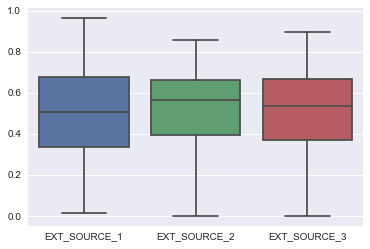

In [131]:
# Boxplots for external credit score variables
sns.boxplot(x=app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]);

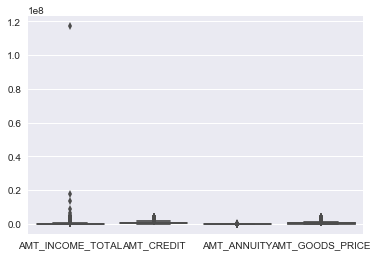

In [134]:
# Boxplots for dollar value variables
sns.boxplot(app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]);

We would generally expect income to be a right-skewed variable, however the boxplot indicates that there are some suspicious outliers near the 120mn mark. Let's investigate further using describe() and a histogram.

In [140]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

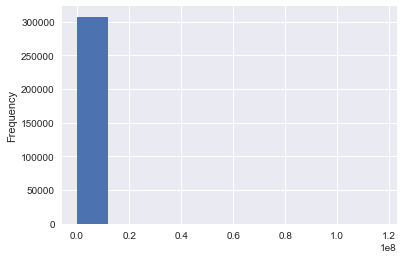

In [139]:
app_train['AMT_INCOME_TOTAL'].plot.hist();

In [147]:
# How many of these cases are there?
inc_anom = app_train[app_train['AMT_INCOME_TOTAL']>1.170000e+08]
print('There are %d anomolous income observations' % len(inc_anom))

There are 1 anomolous income observations


Since there's only one observation this large, it's likely that's it's an erroneous input. We will set the value to missing.

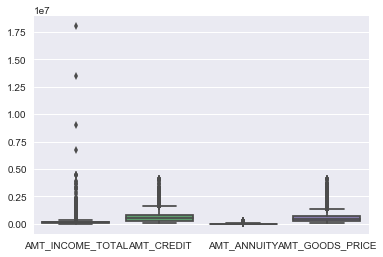

In [150]:
app_train['AMT_INCOME_TOTAL'].replace({1.170000e+08: np.nan}, inplace=True)

# Reproduce the boxplots
sns.boxplot(app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]);

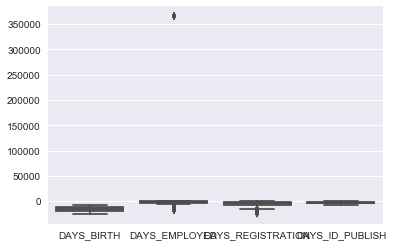

In [151]:
# Check variables measured in days
sns.boxplot(x=app_train[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']]);

It appears as though we have some outliers in DAYS_EMPLOYED. Check by plotting a histogram and looking at the summary statistics.

In [125]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

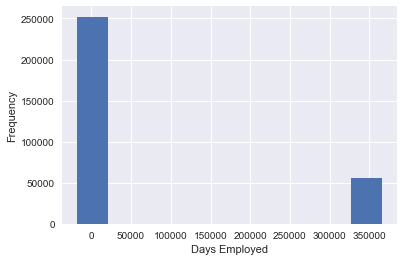

In [130]:
app_train['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employed');

In [156]:
# How many of these cases are there?
emp_anom = app_train[app_train['DAYS_EMPLOYED']==365243]
print('There are %d anomolous days employed' % len(emp_anom))
print('This represents %0.2f%% of the training set.' % (100*len(emp_anom)/len(app_train)))

There are 55374 anomolous days employed
This represents 18.01% of the training set.


This represents a substantial share of the training set. We will do a bit more investigation before setting the values to missing. Let's check if these records tend to have a higher or lower rate of default than the remaining 82% of the set.

In [159]:
non_anom = app_train[app_train['DAYS_EMPLOYED']!=365243]
print('Non-anomalies default on %0.2f%% of loans.' % (100*non_anom['TARGET'].mean()))
print('Anomalies default on %0.2f%% of loans.' % (100*emp_anom['TARGET'].mean()))

Non-anomalies default on 8.66% of loans.
Anomalies default on 5.40% of loans.


There's not a huge difference between the default rate of anomalies and non-anomalies. We will set the outlier values to missing and create a variable to flag the outliers.

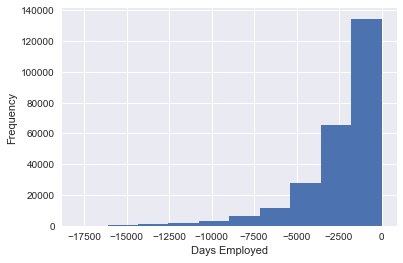

In [161]:
# Create outlier flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED']==365243

# Replace outliers with np.nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employed');

### <font color='orange'>**To be filled in: outlier detection for the remaining variables**</font>

### Correlations
Computing Pearson correlations between features and the target is one way to get an idea about which features may be more interesting or important in determining default probability.

In [162]:
# Compute correlations between features and target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display strongest correlations
print('Most positive correlations:\n', correlations.tail(10))
print('\nMost negative correlations:\n', correlations.head(10))

Most positive correlations:
 DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
DAYS_EMPLOYED_ANOM                  NaN
Name: TARGET, dtype: float64

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
Name: TARGET, dtype: f

The largest positive correlation comes from DAYS_BIRTH, suggesting that there may be some effect of age on default probability. The correlation is positive, but DAYS_BIRTH is measured in days before application date (i.e. the value fo the feature is negative), meaning that an increase in age is associated with a reduction in default probability.

Let's have a closer look at the relationship between age and default probability.

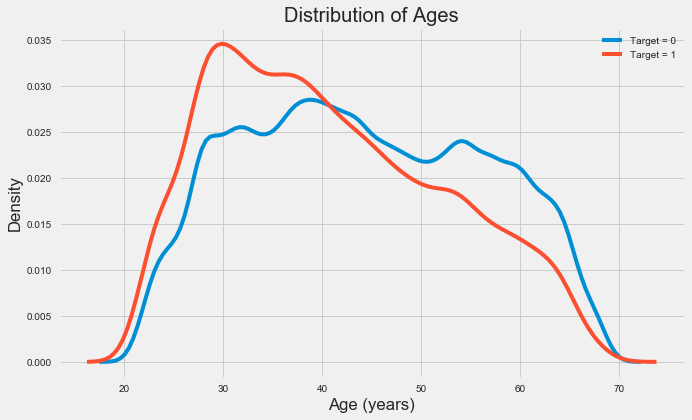

In [168]:
# Produce a KDE plot of age, coloured by default status.

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# DAYS_BIRTH is measured in days, so divide by 365 to get years.
# Multiply by -1 so that age is measured positively.
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH']/365, label = 'Target = 0');
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH']/365, label = 'Target = 1');
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The age distribution of defaulters (red line) is skewed slightly more towards younger ages than the non-defaulters (blue line). Although the correlation coefficient isn't very large, this feature may be important for modelling.

Another way to visualise the relationship is to plot default probability by age group. To do this, first split the data into five-year age group bins. Then compute default probability for each bin and plot in a histogram.

In [170]:
age_data = app_train[['DAYS_BIRTH','TARGET']]
age_data['YEARS_BIRTH'] = -1*age_data['DAYS_BIRTH']/365

# Create binned age variable
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70,11))
age_data.head()

,DAYS_BIRTH,TARGET,YEARS_BIRTH,YEARS_BINNED
0,-9461,1,25.920548,"(25.0, 30.0]"
1,-16765,0,45.931507,"(45.0, 50.0]"
2,-19046,0,52.180822,"(50.0, 55.0]"
3,-19005,0,52.068493,"(50.0, 55.0]"
4,-19932,0,54.608219,"(50.0, 55.0]"


In [181]:
age_grouped = age_data[['YEARS_BINNED','TARGET']].groupby('YEARS_BINNED').mean()
age_grouped

,TARGET
YEARS_BINNED,
"(20.0, 25.0]",0.123036
"(25.0, 30.0]",0.111436
"(30.0, 35.0]",0.102814
"(35.0, 40.0]",0.089414
"(40.0, 45.0]",0.078491
"(45.0, 50.0]",0.074171
"(50.0, 55.0]",0.066968
"(55.0, 60.0]",0.055314
"(60.0, 65.0]",0.052737


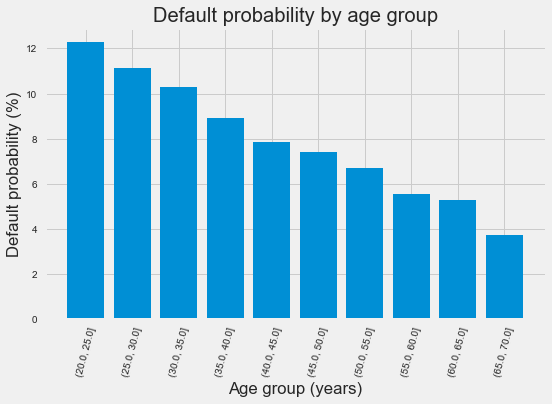

In [200]:
plt.figure(figsize=(8,5));

plt.bar(range(0, len(age_grouped)), 100*age_grouped['TARGET']);
plt.xticks(range(0, len(age_grouped)), [row for row in age_grouped.index.astype(str)],rotation=75);
plt.xlabel('Age group (years)'); plt.ylabel('Default probability (%)'); plt.title('Default probability by age group');

This chart shows a clearer trend: younger people are more likely to default on their loan.

Now let's repeat the above analyses for DAYS_EMPLOYED.

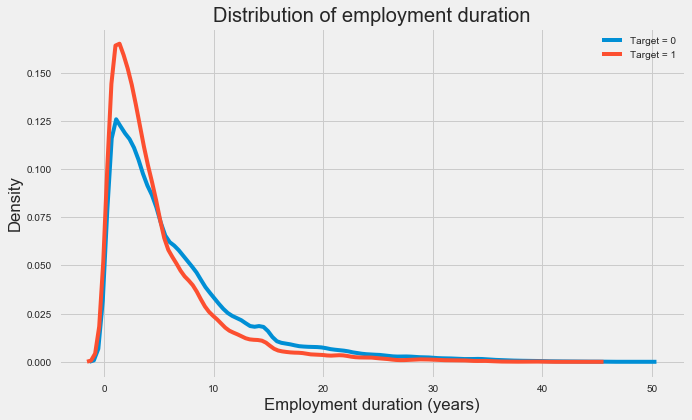

In [205]:
# KDE plot of days employed, coloured by default status.

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

sns.kdeplot(-1*app_train.loc[app_train['TARGET']==0, 'DAYS_EMPLOYED']/365, label = 'Target = 0');
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==1, 'DAYS_EMPLOYED']/365, label = 'Target = 1');
plt.xlabel('Employment duration (years)'); plt.ylabel('Density'); plt.title('Distribution of employment duration');

There's not a big difference in the distribution of length of employment between the two default statuses. Let's see if hte binned histogram provides any mroe information.

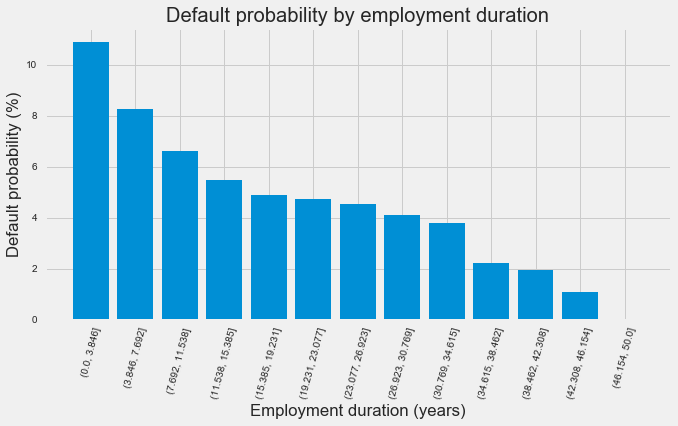

In [210]:
emp_data = app_train[['DAYS_EMPLOYED','TARGET']]
emp_data['YEARS_EMPLOYED'] = -1*emp_data['DAYS_EMPLOYED']/365

# Create binned age variable
emp_data['YEARS_BINNED'] = pd.cut(emp_data['YEARS_EMPLOYED'], bins = np.linspace(0,50,14))
emp_grouped = emp_data[['YEARS_BINNED','TARGET']].groupby('YEARS_BINNED').mean()

plt.figure(figsize=(10,5));

plt.bar(range(0, len(emp_grouped)), 100*emp_grouped['TARGET']);
plt.xticks(range(0, len(emp_grouped)), [row for row in emp_grouped.index.astype(str)],rotation=75);
plt.xlabel('Employment duration (years)'); plt.ylabel('Default probability (%)'); plt.title('Default probability by employment duration');

Now we will look at the three variables with the strongest negative correlation with the target: the three external credit score variables. The negative correlation indicates that the higher the external credit score, the less likely a person is to default on their loan.

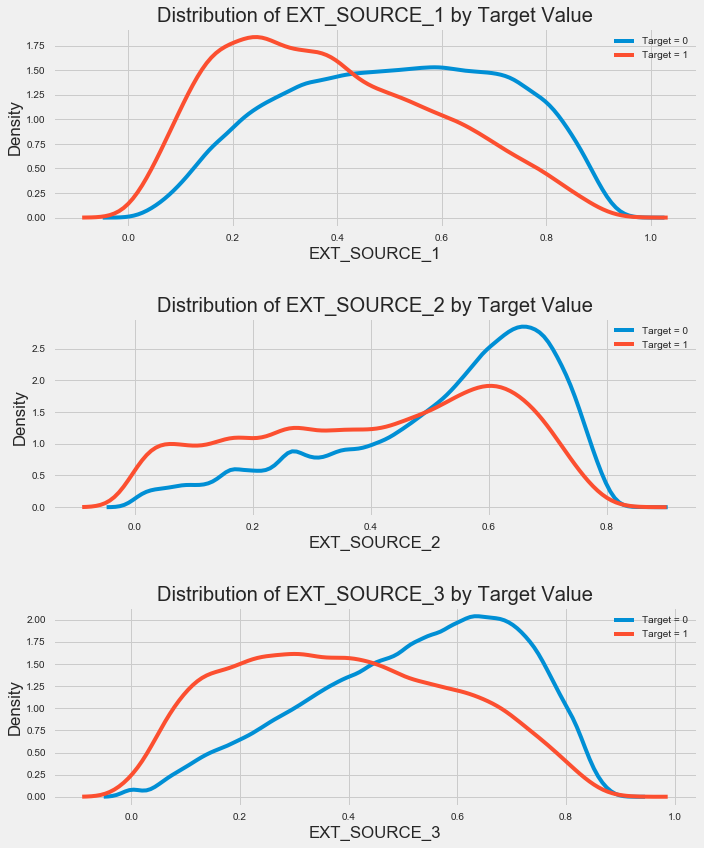

In [211]:
# Produce KDE plots for each of the external credit score variables, coloured by default status.

plt.figure(figsize = (10, 12))

# Iterate over each feature
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Create a new subplot for each variable
    plt.subplot(3, 1, i+1)
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label = 'Target = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label = 'Target = 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

The largest difference in profiles can be seen for the third external source feature. 